# Table of Contents
 <p>

Modules

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from mpl_toolkits.basemap import Basemap
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from netCDF4 import Dataset
from math import *
import glob
import string
import re
from datetime import date, time, datetime
from pprint import pprint
import sys,os
import csv
import pandas as pd
import pickle
import matplotlib.transforms as mtransforms
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import matplotlib.transforms as mtransforms

Paths

In [7]:
# Add ../functions to system path
currentpath = %pwd
currentpath = str(currentpath)
##-- In a python script do the following instead:
##-- currentpath = os.path.dirname(os.path.realpath(__file__))
sys.path.insert(0,currentpath[:currentpath.rfind('/')+1]+'functions')

## Fixed data files input directory
inputdir = '/Users/bfildier/Data/simulations'
inputdir_fx = '/Users/bfildier/Data/preprocessed/allExperiments/fx'
## Dataframe input directory
# resultdir = os.path.join(os.path.dirname(currentpath),'results')
resultdir = os.path.join(os.path.dirname(currentpath),'results/fullResults')
## Maps (2D tropical data files) input directory
inputdir_maps = os.path.join(os.path.dirname(currentpath),'inputs/forMaps')

##-- Output directories --##
## Figures
figdir = os.path.join(os.path.dirname(currentpath),'figures/fullResults')


Own modules and functions

In [3]:
from importingData import *
from extremeScaling import *
from thermodynamics import *
from thermo_funcs import *
from thermo_constants import *

Graphical parameters

In [28]:
###--- Set up graphical parameters ---###

%load_ext autoreload
%autoreload 2

##-- Figure setup --##
plt.rcParams.update({'axes.labelsize': 'x-large',
                     'axes.titlesize': 'x-large',
                     'xtick.labelsize': 'large',
                     'ytick.labelsize': 'large',
                     'figure.titlesize': 'xx-large',
                     'figure.subplot.top': '0.87',
                     'figure.subplot.wspace': '0.3',
                     'figure.subplot.hspace': '0.3',
                     'legend.fontsize':'medium'})

##-- Load colors for plots --##
colorfile = os.path.join(currentpath,'colorsAndTypes.pickle')
with open(colorfile,'rb') as handle:
    col = pickle.load(handle)
    lt = pickle.load(handle)
    pal = pickle.load(handle)
    lw = pickle.load(handle)
    dashes = pickle.load(handle)
    mark = pickle.load(handle)
    cmaps = pickle.load(handle)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Global variables and datasets

In [10]:
###--- Datasets ---###

## Dataset parameter sets and variable sets
compsets = ("FSPCAMm_AMIP","FAMIPC5")
experiments = ("piControl","abrupt4xCO2")
subsets = ("tropics","ocean","land","mfzero")
subsets_for_comp = dict(zip(compsets,(subsets,subsets[:-1])))

## Individual names
compset_SPCAM, compset_CAM5 = compsets
experiment_PI, experiment_4xCO2 = experiments
subset_all, subset_ocean, subset_land, subset_mf = subsets


##--- Related to scaling ---##

## Simulation vs. pr scaling
pr_types = ["simulated","scaling_1","scaling_2","scaling_3","scaling_4","scaling_5","scaling_6","scaling_7"]
## Contributions to fractional changes
# contributions = ["mass","thermo","dyn_mean","dyn_profile","pressure","non_linear","all"]
# contributions_labs = ["Mass","Thermodynamic",r"Mass flux",r"Profile shift","Pressure","Non linear","Sum"]
contributions = ["thermo","dyn_mean","dyn_mean_th","dyn_mean_dyn","dyn_profile","non_linear","all"]
contributions_labs = ["Thermodynamic",r"Mass flux",r"Mass flux ($\Delta \rho$)",r"Mass flux ($\Delta w$)",
                      r"Profile shift","Non linear","Sum"]
contributions_labels = dict(zip(contributions,contributions_labs))

###--- Variables ids ---###

## All pr ids
pr_ids = ["PRECT","CRM_PREC_I90","CRM_PREC_I75","CRM_PREC_I50","CRM_PREC_I25","CRM_PREC_I10"]
# pr_ids = ["PRECT","CRM_PREC_I50"]
gcm_pr_id = pr_ids[0]
crm_pr_ids = pr_ids[1:]
pr_ids_for_compset = {compsets[0]:pr_ids, compsets[1]:[gcm_pr_id]}

area_id_root = "PRECAREA_"
area_ids = [area_id_root+crm_pr_id.split('_')[-1] for crm_pr_id in crm_pr_ids]

frac_id_root = "PRECFRAC_"
frac_ids = [frac_id_root+crm_pr_id.split('_')[-1] for crm_pr_id in crm_pr_ids]

## Define IDs of variables required for plotting profiles
varids_for_profiles = {"PRECT":('PS','T','Q','RELHUM','OMEGA','W')}
for f in [90,75,50,25,10]:
#     varids_for_profiles["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'CRM_QC_I%s'%str(f),'CRM_H_I%s'%str(f),
#                                            'CRM_OMEGA_I%s'%str(f),'CRM_W_I%s'%str(f))
    varids_for_profiles["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'Q','CRM_H_I%s'%str(f),
                                           'CRM_OMEGA_I%s'%str(f),'CRM_W_I%s'%str(f))

## Define IDs of variables required for computing scaling
varids_for_scaling = {"PRECT":('PS','T','OMEGA')}
varids_for_scaling_2 = {"PRECT":('PS','T','QVSATENV_MESO','OMEGA')}
varids_for_scaling_3 = {"PRECT":('PS','T','OMEGA')}
varids_for_scaling_4 = {"PRECT":('PS','T','OMEGA')}
varids_for_scaling_5 = {"PRECT":('PS','T','OMEGA')}
varids_for_scaling_6 = {"PRECT":('PS','T','OMEGA')}
varids_for_scaling_7 = {"PRECT":('PS','T','OMEGA')}
varids_for_scaling_8 = {"PRECT":('PS','T','OMEGA')}
# for f in [90,75,50,25,10]:
#     varids_for_scaling["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'CRM_OMEGA_I%s'%str(f))
for f in [90,75,50,25,10]:
    varids_for_scaling_3["CRM_PREC_I%s"%str(f)] = ('PS','T','OMEGA_CRM_W_I%s'%str(f),'RHO_MESO',\
                                                   'CRM_W_I%s'%str(f),'Q','QVSATENV')
    varids_for_scaling_4["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'OMEGA_CRM_W_I%s'%str(f),\
                                                   'RHO_MESO','CRM_W_I%s'%str(f),'Q','QVSATENV_CRM_T_I%s'%str(f))
    varids_for_scaling_5["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'OMEGA_CRM_WT_I%s'%str(f),\
                                                   'RHO_CRM_T_I%s'%str(f),'CRM_W_I%s'%str(f),'Q',\
                                                   'QVSATENV_CRM_T_I%s'%str(f))
    varids_for_scaling_6["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'CRM_OMEGA_I%s'%str(f))
    varids_for_scaling_7["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'CRM_OMEGA_WT_I%s'%str(f))
    varids_for_scaling_8["CRM_PREC_I%s"%str(f)] = ('PS','T','CRM_OMEGA_I%s'%str(f))

## Define percentile values
Q_IL_ext = np.array([90.0, 92.0567, 93.6904, 94.9881, 96.0189, 96.8377, 97.4881, 98.0047, 98.4151, 98.7411,
        99.0, 99.2057, 99.369, 99.4988, 99.6019, 99.6838, 99.7488, 99.8005, 99.8415, 99.8741,
        99.9, 99.9206, 99.9369, 99.9499, 99.9602, 99.9684, 99.9749, 99.98, 99.9842, 99.9874,
        99.99, 99.9921, 99.9937, 99.995, 99.996, 99.9968, 99.9975, 99.998, 99.9984, 99.9987])
Q_IL_ext_colorbar = np.array([90.0, 92.0567, 93.6904, 94.9881, 96.0189, 96.8377, 97.4881, 98.0047, 98.4151, 98.7411,
        99.0, 99.2057, 99.369, 99.4988, 99.6019, 99.6838, 99.7488, 99.8005, 99.8415, 99.8741,
        99.9, 99.9206, 99.9369, 99.9499, 99.9602, 99.9684, 99.9749, 99.98, 99.9842, 99.9874,
        99.99, 99.9921, 99.9937, 99.995, 99.996, 99.9968, 99.9975, 99.998, 99.9984, 99.9987,99.999])
Qs = [90.,96.8377,99.,99.6838,99.9,99.9684,99.99,99.9968]
Q_ids = ['90.0','96.8377','99.0','99.6838','99.9','99.9684','99.99','99.9968']

###--- Legends, titles and labels ---###
    
## Corresponding legend labels
compset_labs = ["SPCAM","CAM5"]
compset_labels = dict(zip(compsets,compset_labs))

exp_labs = ["Pre-industrial","4xCO2"]
exp_labels = dict(zip(experiments,exp_labs))

subset_labs = ["Tropics","Tropical oceans","Tropical land","Zero mass flux"]
subset_labels = dict(zip(subsets,subset_labs))

pr_labs = [r"$P(GCM)$",r"$P(CRM)$ largest $90\%$",r"$P(CRM)$ largest $75\%$",r"$P(CRM)$ largest $50\%$",
             r"$P(CRM)$ largest $25\%$",r"$P(CRM)$ largest $10\%$"]
pr_labels = dict(zip(pr_ids,pr_labs))
pr_labs_short = [r"$P(GCM)$",r"${\left[P(CRM)\right]}^{90\%}$",r"${\left[P(CRM)\right]}^{75\%}$",
                 r"${\left[P(CRM)\right]}^{50\%}$",
             r"${\left[P(CRM)\right]}^{25\%}$",r"${\left[P(CRM)\right]}^{10\%}$"]
pr_labels_short = dict(zip(pr_ids,pr_labs_short))
pr_labs_veryshort = [r"$P_{GCM}$",r"$P_{CRM}^{90\%}$",r"$P_{CRM}^{75\%}$",
                 r"$P_{CRM}^{50\%}$",r"$P_{CRM}^{25\%}$",r"$P_{CRM}^{10\%}$"]
pr_labels_veryshort = dict(zip(pr_ids,pr_labs_veryshort))
pr_labs_vvshort = [r"$P_{GCM}$",r"$P_{CRM}$",r"$P_{CRM}$",r"$P_{CRM}$",r"$P_{CRM}$",r"$P_{CRM}$"]
pr_labels_vvshort = dict(zip(pr_ids,pr_labs_vvshort))


###--- Results and others ---###

## Vertical pressure coordinate function
lev_file = 'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'
computeP = getPressureCoordinateFunction(os.path.join(inputdir_fx,lev_file))

# ## Import all dataframes
# df_quantile = getStatDataFrame("pr_quantile_IL",compsets,experiments,subsets,resultdir)
# df_density2D = getStatDataFrame("pr_jointDensity_IL",compsets,experiments,subsets,resultdir)
# df_mean = getStatDataFrame("var2D_mean",compsets,experiments,subsets,resultdir)
# df_meanProfile = getStatDataFrame("var3D_meanProfile",compsets,experiments,subsets,resultdir)
# df_meanAtQ = getStatDataFrame("var2D_meanAtQ",compsets,experiments,subsets,resultdir)
# df_meanProfileAtQ = getStatDataFrame("var3D_meanProfileAtQ",compsets,experiments,subsets,resultdir)

In [54]:
area_id = 'area'
# areafile = 'areacella_fx_CESM1-CAM5_piControl_r0i0p0.nc'
areafile = 'area.1.9x2.5.nc'
earth_radius = 6371000.0 #m
area = getVar(area_id,inputdir_fx,inputfiles=[os.path.join(inputdir_fx,areafile)])
# area = getVar(area_id,inputdir_fx,inputfiles=[os.path.join(inputdir_fx,areafile)])*earth_radius**2

experiment = experiment_PI
compset = compset_SPCAM


fsnt = {}
flnt = {}
time = {}
for compset in compsets:
    fsnt[compset] = {}
    flnt[compset] = {}
    time[compset] = {}
    for experiment in experiments:
        
        case = "bf_%s_%s"%(compset,experiment)
        fsnt_id = "FSNT"
        flnt_id = "FLNT"
        time_id = "time"
        indir = os.path.join(inputdir,case)
        inputfile = os.path.join(indir,"%s.cam.h1.1850-05-02.1851-05-03.nc"%case)
        fsnt[compset][experiment] = getVar(fsnt_id,indir,inputfiles=[inputfile])
        flnt[compset][experiment] = getVar(flnt_id,indir,inputfiles=[inputfile])
        time[compset][experiment] = getVar(time_id,inputdir,inputfiles=[inputfile])

In [55]:
print "Compute global means"

area_global = area.sum()
# print area_global
fsnt_global = {}
flnt_global = {}
for compset in compsets:
    fsnt_global[compset] = {}
    flnt_global[compset] = {}
    for experiment in experiments:
        fsnt_global[compset][experiment] = np.multiply(fsnt[compset][experiment],\
                                                       np.moveaxis(np.repeat(area[...,np.newaxis],\
                                                                             time[compset][experiment].size,\
                                                                             len(area.shape)),\
                                                                   -1,0)).sum(axis=(1,2))/area_global
        flnt_global[compset][experiment] = np.multiply(flnt[compset][experiment],\
                                                       np.moveaxis(np.repeat(area[...,np.newaxis],\
                                                                             time[compset][experiment].size,\
                                                                             len(area.shape)),\
                                                                   -1,0)).sum(axis=(1,2))/area_global

Compute global means


Make plots

Global annual mean top-of-model imbalance (SPCAM, piControl):	-0.79633472056 W/m2
Global annual mean top-of-model imbalance (SPCAM, abrupt4xCO2):	-3.21165637149 W/m2
Global annual mean top-of-model imbalance (CAM5, piControl):	0.0602226628387 W/m2
Global annual mean top-of-model imbalance (CAM5, abrupt4xCO2):	-0.743081236939 W/m2


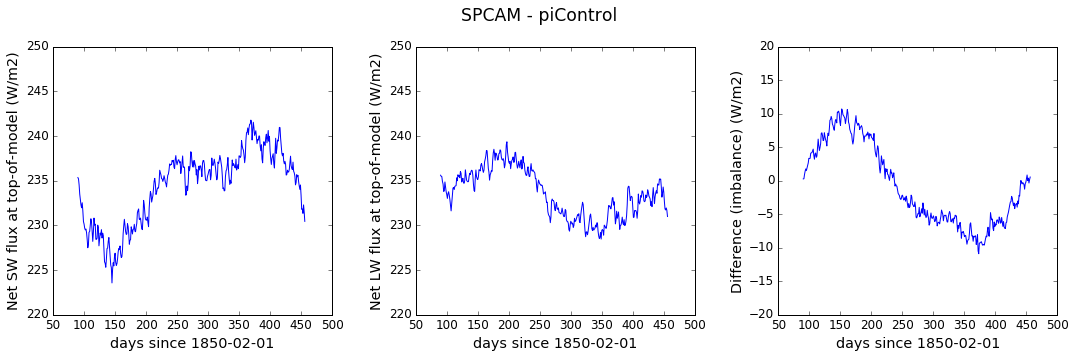

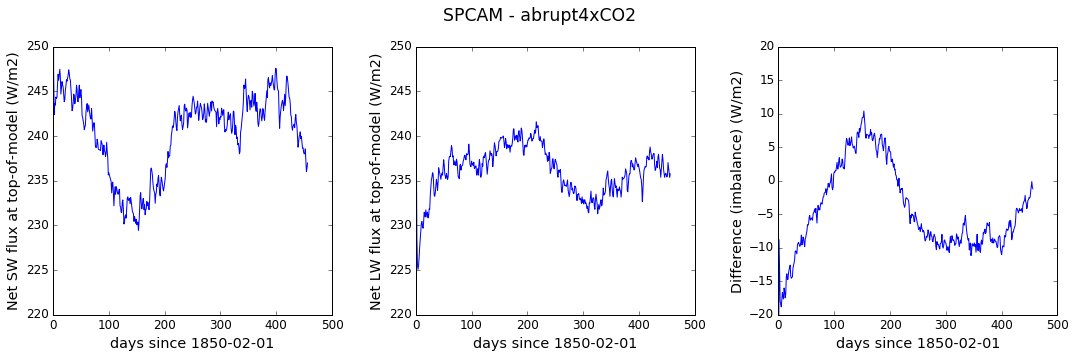

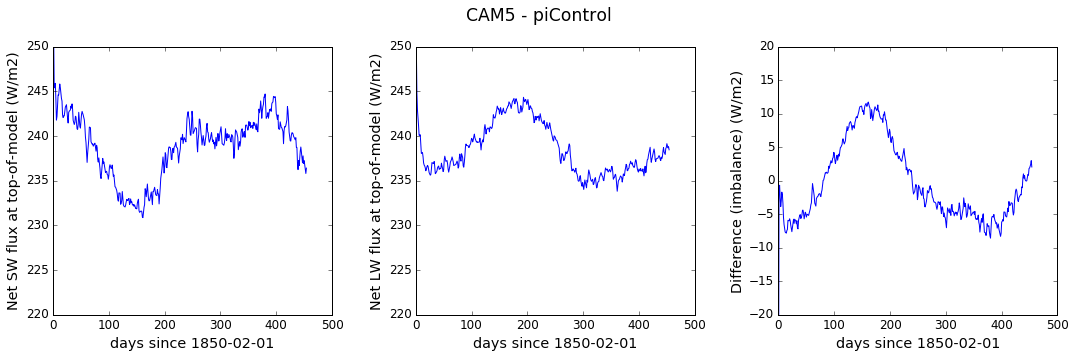

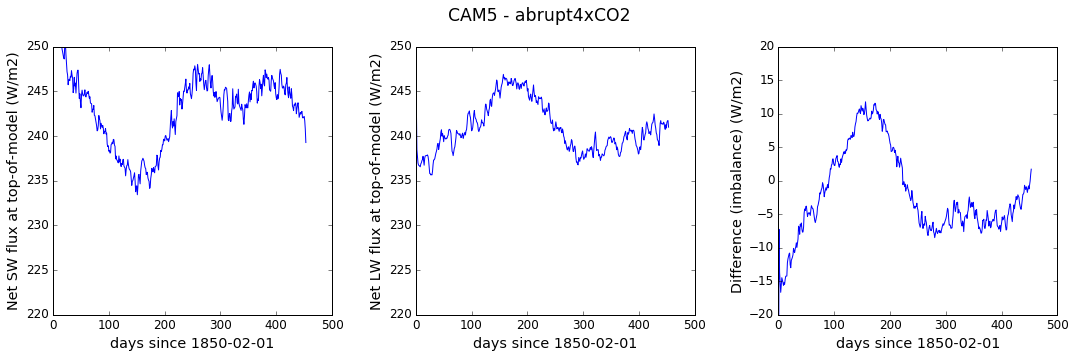

In [68]:
print "Make plots"
print

for compset in compsets:

    for experiment in experiments:

        fig, ax = plt.subplots(ncols=3,nrows=1,figsize=(18,5))
        ax[0].plot(time[compset][experiment],fsnt_global[compset][experiment])
        ax[1].plot(time[compset][experiment],flnt_global[compset][experiment])
        ax[2].plot(time[compset][experiment],flnt_global[compset][experiment]-fsnt_global[compset][experiment])

#         ylabs = ["%s (W/m2)"%v for v in (fsnt_id,flnt_id,"%s-%s"%(fsnt_id,flnt_id))]
        ylabs = ["%s (W/m2)"%v for v in ("Net SW flux at top-of-model","Net LW flux at top-of-model","Difference (imbalance)")]
        for i,ylab in zip(range(len(ax)),ylabs):
            ax[i].set_xlabel("days since 1850-02-01")
            ax[i].set_ylabel(ylab)
        ax[0].set_ylim((220,250))
        ax[1].set_ylim((220,250))
        ax[2].set_ylim((-20,20))
        fig.suptitle("%s - %s"%(compset_labels[compset],experiment))

        print "Global annual mean top-of-model imbalance (%s, %s):\t"%(compset_labels[compset],experiment), 
        print (flnt_global[compset][experiment]-fsnt_global[compset][experiment])[-365:].mean(), "W/m2"
        
        plt.savefig(os.path.join(figdir,"fig_TOA_fluxes_%s_%s.pdf"%(compset,experiment)),
            bbox_inches='tight')
#         plt.show()
